In [72]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import ndtr
from scipy.interpolate import InterpolatedUnivariateSpline
import warnings
warnings.filterwarnings("ignore")

In [73]:
def filterData(df):
    ''' Filters the option chain '''
    # drop low Bids and Asks 
    df = df[(df['Bid'] >= 0.001) | (df['Ask'] >= 0.001)]
    df[['Bid', 'Ask']] = np.where(df[['Bid', 'Ask']] < 0.001, np.nan, df[['Bid', 'Ask']])
    # drop wide Bid Ask spreads
    df = df[~(df['Ask'] > 4 * df['Bid'])]
    # Calculate Mid price for options with both valid Bid and Ask
    df['Mid'] = (df['Bid'] + df['Ask']) / 2
    
    # Format dates
    df[['Effective Date', 'Expiry Date', 'Last Trade Date']] = (
        df[['Effective Date', 'Expiry Date', 'Last Trade Date']]\
        .apply(pd.to_datetime, format='%m-%d-%Y')
        )   
    df['Tenor'] = np.round((df['Expiry Date'] - df['Effective Date']).dt.days / 365, 6)
    
    # Drop options with very stale last trade date
    df = df[df['Last Trade Date'] >= (df['Effective Date'] - pd.offsets.BusinessDay(n=5))]            
    
    df = df.sort_values(by=['Tenor', 'Strike'])
    tenors = df['Tenor'].unique()
    total = []
    for i in range(len(tenors)):
        t_options = df[df['Tenor']==tenors[i]].loc[:]
        # Drop options with spreads > 3 standard deviation of the average spread for given maturity
        t_options['Spread'] = t_options['Ask'] - t_options['Bid']
        mu = t_options['Spread'].mean()
        sd = t_options['Spread'].std()
        t_options = t_options[~(t_options['Spread'] >= mu + 3 * sd)].drop('Spread', axis=1)
        total.append(t_options)
    df = pd.concat(total, ignore_index=True)
    return df

In [74]:
def EstimateForwards(options, interp_DF):
    tenors = options['Tenor'].unique()
    df_fwd = pd.DataFrame()
    for i in range(len(tenors)):
        D = interp_DF(tenors[i]) # interpolate discount factor
        calls = df[(options['Tenor']==tenors[i]) & (options['Option Type']=='Call')].loc[:][['Strike', 'Bid', 'Ask', 'Mid']]
        puts = df[(options['Tenor']==tenors[i]) & (options['Option Type']=='Put')].loc[:][['Strike', 'Bid', 'Ask', 'Mid']]
        data = pd.merge(calls, puts, on='Strike')
        data = data.dropna(ignore_index=True)
        if len(data)==0: continue
        temp1 = data['Strike'] + (data['Bid_x'] - data['Bid_y']) / D
        temp2 = data['Strike'] + (data['Ask_x'] - data['Ask_y']) / D
        data['low_f'] = np.minimum(temp1, temp2)
        data['high_f'] = np.maximum(temp1, temp2)
        data['Mid_f'] = data['Strike'] + (data['Mid_x'] - data['Mid_y']) / D
        
        max_iter = 10
        j = 0
        fwd = np.mean(data['Mid_f'])
        while j <= max_iter:
            data1 = data[(data['Strike'] < fwd) & (data['low_f'] < fwd) &
                         (data['high_f'] > fwd)].tail(1)
            data2 = data[(data['Strike'] > fwd) & (data['low_f'] < fwd) &
                         (data['high_f'] > fwd)].head(1)
            if len(data1)==0 and len(data2)==0: break
            else:
                new_forward = pd.concat([data1, data2])['Mid_f'].mean()
                change = abs(new_forward - fwd) / fwd
                fwd = new_forward
                if len(data1)==1 and len(data2)==1 and \
                (data2.iloc[0,0] < new_forward or data1.iloc[0,0] > new_forward) : continue
                if change < 0.001: break
            j += 1
        df_fwd.loc[i, 'Tenor'] = tenors[i]
        df_fwd.loc[i, 'Forward'] = fwd
        df_fwd.loc[i, 'Disc Factor'] = D
        df_fwd = df_fwd.dropna()
    return df_fwd

In [88]:
def black_model(F, K, T, df, sigma, phi, calc_vega=False):
    """
    Black model for valuing vanilla european options
    phi = 1 for call options and -1 for put options
    """
    d1 = (np.log(F / K) + (0.5 * sigma**2 * T)) / (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))
    price = df * phi * (F * ndtr(phi * d1) - K * ndtr(phi * d2))
    if calc_vega: 
        vega = df * F * norm._pdf(d1) * np.sqrt(T)
        return price, vega
    return price


def implied_volatility(P, F, K, T, df, phi):
    max_iter = 200
    epsilon = 1.0e-5
    sigma = 0.5
    for i in range(max_iter):
        price, vega = black_model(F, K, T, df, sigma, phi, True)
        diff = P - price  
        if (abs(diff) < epsilon):
            return sigma
        sigma = sigma + diff/vega 
    return np.nan 

vec_bs_imp_vol = np.vectorize(implied_volatility)


## __Positivie Variance__

In [76]:
def PositiveVariance(knots, n_strikes, basis_matrices):
    """
    Parameters
    ----------
    knots : (np.ndarray): array of z value cubic knots across tenors
    n_strikes : (int): number of strikes where the constraint is enforced
    basis_matrices : (np.ndarray): Array of matrix representations of uniform B-splines
    """
    m, n = knots.shape
    z_grid = np.linspace(knots[0][0], knots[0][-1], n_strikes)
    z0_inds = len(knots[0]) - np.argmax(np.flipud(knots[0].reshape(-1, 1) <= z_grid), axis=0) - 1
    z0_inds[-1] = n-2
    h = knots[0][1] - knots[0][0]
    A = np.zeros((n_strikes, (n + 2) * m))
    for i in range(n_strikes):
        z = z_grid[i]
        z0 = knots[0][z0_inds[i]]
        A[i, z0_inds[i] : z0_inds[i] + 4 ] = -(
        (basis_matrices[z0_inds[i]][0] / h**3) * (z - z0  )**3 +
        (basis_matrices[z0_inds[i]][1] / h**2) * (z - z0)**2 +
        (basis_matrices[z0_inds[i]][2] / h) * (z - z0) +
        (basis_matrices[z0_inds[i]][3])
        )
    # Define upper bounds
    ub = np.full(len(A), -1e-6)
    return A, ub

## __Linear Wing Extrapolation__

In [77]:
def LinearWingExtrapolation(knots, basis_matrices):
    """
    Parameters
    ----------
    knots : (np.ndarray): array of z value cubic knots across tenors
    basis_matrices : (np.ndarray): Array of matrix representations of uniform B-splines
    """
    m, n = knots.shape
    A = np.zeros((2 * m, (n + 2) * m))
    for i in range(m):
        h =  knots[i][1] - knots[i][0]
        row = 2 * i
        col = i * (n + 2)
        # Z0 knot
        A[row, col :col + 4] = 2 * basis_matrices[0][1] / h**2
        # Zn-1 knot
        A[row + 1, col + (n + 2) - 4 : col + (n + 2)] = (
            (6 * basis_matrices[-1][0] /  h**2) +
            (2 * basis_matrices[-1][1] / h**2)
        )
    b = np.zeros(len(A))
    return A, b

## __Upward Sloping Wings__

In [78]:
def UpwardSlopingWings(knots, basis_matrices):
    """
    Parameters
    ----------
    knots : (np.ndarray): array of z value cubic knots across tenors
    basis_matrices : (np.ndarray): Array of matrix representations of uniform B-splines
    """
    m, n = knots.shape
    A = np.zeros((2 * m, (n + 2) * m))
    for i in range(m):
        h = knots[i][1] - knots[i][0]
        row = 2 * i
        col = i * (n + 2)
        # Z0 knot
        A[row, col : col + 4] = basis_matrices[0][2] / h

        # Zn-1 knot
        A[row + 1, col + (n + 2) - 4 : col + (n + 2)] = -(          
            (3 * basis_matrices[-1][0] / h)  +
            (2 * basis_matrices[-1][1] / h) +
            (basis_matrices[-1][2] / h)
        )
    # Initialize upper bounds
    ub = np.full(2 * m, -1e-6)
    return A, ub

## __Roger Lee Moment__

In [79]:
def RogerLeeMoment(knots, tenors, est_atmf_vols, basis_matrices):
    """
    Parameters
    ----------
    knots : (np.ndarray): array of z value cubic knots across tenors
    tenors : (np.ndarray): array of option tenors
    est_atmf_vols : (np.ndarray): array of estimated ATMF vol for each tenor 
    basis_matrices : (np.ndarray): Array of matrix representations of uniform B-splines
    """
    m, n = knots.shape
    m = len(tenors)
    A = np.zeros((2 * m, (n + 2) * m))
    ub = np.repeat(2 * est_atmf_vols / np.sqrt(tenors), 2) - 1e-8
    for i in range(m):
        h = knots[i][1] - knots[i][0]
        row = 2 * i
        col = i * (n + 2)
        # Z0 knot
        A[row, col : col + 4] = -basis_matrices[0][2] / h
            
        # Zn-1 knot
        A[row + 1, col + (n + 2) - 4 : col + (n + 2)] = ( 
            (3 * basis_matrices[-1][0] / h) + 
             (2 * basis_matrices[-1][1] / h) + 
             (basis_matrices[-1][2] / h)
        )
    return A, ub

## __No Calendar Spread Arbitrage__

In [80]:
def NoCalendarSpreadArbitrage(n_strikes, knots, k_knots, tenors, est_atmf_vols, basis_matrices):
    m, n = knots.shape 
    A = np.zeros((n_strikes * (m - 1), m * (n + 2)))
    for i in range(m-1):
        T1 = tenors[i]
        T2 = tenors[i + 1]
        h1 = knots[i,1] - knots[i,0]           
        h2 = knots[i + 1, 1] - knots[i + 1, 0]
        sigma1 = est_atmf_vols[i]
        sigma2 = est_atmf_vols[i + 1]
        # Z0 knot
        col1 = i * (n + 2)
        col2 = col1 + (n + 2)
        A[i * n_strikes,  col1 : col1 + 4] = -(np.sqrt(T1) / sigma1) * basis_matrices[0][2] / h1
        A[i * n_strikes,  col2 : col2 + 4] = (np.sqrt(T2) / sigma2) * basis_matrices[0][2] / h2
        # Internal knots
        k_grid = np.linspace(max(k_knots[i,0], k_knots[i+1,0]), min(k_knots[i,-1], k_knots[i+1,-1]), n_strikes)
        for j in range(1, n_strikes-1):
            z1 = k_grid[j] / (sigma1 * T1**0.5)
            z2 = k_grid[j] / (sigma2 * T2**0.5)
            ind1 = np.where(knots[i] <= z1)[0][-1]
            ind2 = np.where(knots[i+1] <= z2)[0][-1]
            x1 = z1 - knots[i, ind1]
            x2 = z2 - knots[i+1, ind2]
            v1 = np.sum((basis_matrices[ind1].T * [(x1/h1)**j for j in range(3,-1,-1)]).T, axis=0)
            v2 = np.sum((basis_matrices[ind2].T * [(x2/h2)**j for j in range(3,-1,-1)]).T, axis=0)
            row = i * n_strikes + j
            col1 = i * (n + 2) + ind1
            col2 = (i+1) * (n + 2) + ind2
            A[row, col1 : col1 + 4] = T1 * v1            
            A[row, col2 : col2 + 4] = -T2 * v2 
        # Zn-1 knot
        col = (i+1)*(n+2)
        A[row + 1,  col - 4 : col ] = (np.sqrt(T1) / sigma1) * (
        (3 * basis_matrices[-1][0] / h1) +
        (2 * basis_matrices[-1][1] / h1) +
        (basis_matrices[-1][2] / h1)
        )
        
        A[row + 1,  col + (n+2) - 4 : col + (n+2) ] = -(np.sqrt(T2) / sigma2) * (
        (3 * basis_matrices[-1][0] / h2) +
        (2 * basis_matrices[-1][1] / h2) +
        (basis_matrices[-1][2] / h2)
        ) 
    ub = np.full(len(A), -1e-7)
    return A, ub


## __No Butterfly Arbitrage Helper Functions__

In [81]:
def pdf_Smin(v, T, atmf_vol_est, m):
    """
    Returns the value of Smin and it's derivative w.r.t v at the reference variance input
    Parameters
    ----------
    v : (float): variance
    T : (float): tenor
    atmf_vol_est : (float): estimated ATMF vol for the given tenor 
    m : (float): Log moneyness Log(K/F)
    """
    term1 = (0.25 * v**2 * T**2 + v*T)
    term2 = term1**0.5
    term3 = m**2 - term1
    term4 = (-T - 0.5 * v * T**2)
    term5 = 2 * term2
    term6 = -m - term2
    term7 = ((term3 * (term4 / term5)) - (term6 * term4)) / term3**2
    term8 = (-2 * T**0.5) / atmf_vol_est
    val = (v * term8) * (term6 / term3)
    der = (v * term8 * term7) + ((term6 / term3) * term8)
    return val, der


def pdf_Smax(v, T, atmf_vol_est, m):
    """
    Returns the value of Smax and it's derivative w.r.t v at the reference variance input
    Parameters
    ----------
    v : (float): variance
    T : (float): tenor
    atmf_vol_est : (float): estimated ATMF vol for the given tenor 
    m : (float): Log moneyness Log(K/F)
    """
    term1 = (0.25 * v**2 * T**2 + v*T)
    term2 = term1**0.5
    term3 = m**2 - term1
    term4 = (-T - 0.5 * v * T**2)
    term5 = 2 * term2
    term6 = m - term2
    term7 = ((term3 * (term4 / term5)) - (term6 * term4)) / term3**2
    term8 = (2 * T**0.5) / atmf_vol_est
    val = (v * term8) * (term6 / term3)
    der = (v * term8 * term7) + ((term6 / term3) * term8)
    return val, der


def cdf_sMin(v, T, atmf_vol_est, m, d1, n_d1, n_d2, N_d2):
    """
    Returns the value of Smax and it's derivative w.r.t v at the reference variance input
    Parameters
    ----------
    v : (float): variance
    T : (float): tenor
    atmf_vol_est : (float): estimated ATMF vol for the given tenor 
    m : (float): Log moneyness Log(K/F)
    d1 : (float): Black Scholes d1 at the reference variance input
    n_d1 : (float): standard normal pdf at d1
    n_d2 : (float): standard normal pdf at d2
    N_d2 : (float): standard normal cdf at d2
    """
    term1 = ( -n_d2 * (2*m - v*T) + (1 - N_d2) * d1 * (2*m + v*T) ) / (n_d1 * 4 * v * (v * T)**0.5)
    term2 = (1 - N_d2) / n_d1
    term3 = np.exp(m) / atmf_vol_est
    term4 = v**0.5
    term5 = -term3 / term4
    term6 = -2 * term3 * term4
    der = term6 * term1 + term2 * term5
    val = term6 * term2
    return val, der


def cdf_sMax(v, T, atmf_vol_est, m, d1, n_d1, n_d2, N_d2):
    """
    Returns the value of Smax and it's derivative w.r.t v at the reference variance input
    Parameters
    ----------
    v : (float): variance
    T : (float): tenor
    atmf_vol_est : (float): estimated ATMF vol for the given tenor 
    m : (float): Log moneyness Log(K/F)
    d1 : (float): Black Scholes d1 at the reference variance input
    n_d1 : (float): standard normal pdf at d1
    n_d2 : (float): standard normal pdf at d2
    N_d2 : (float): standard normal cdf at d2
    """
    term1 = ( n_d2 * (2*m - v*T) + N_d2 * d1 * (2*m + v*T) ) / (n_d1 * 4 * v * (v * T)**0.5)
    term2 = N_d2 / n_d1
    term3 = np.exp(m) / atmf_vol_est
    term4 = v**0.5
    term5 = term3 / term4
    term6 = 2 * term3 * term4
    der = term6 * term1 + term2 * term5
    val = term6 * term2
    return val, der


def PrepareButterfly(weights, knots, n_strikes, basis_matrices, est_atmf_vols, tenors):
    """
    Parameters
    ----------
    weights : (np.ndarray): array of uniform B-spline weights
    knots : (np.ndarray): array of z value cubic knots across tenors
    n_strikes : (int): number of strikes where the constraint is enforced
    basis_matrices : (np.ndarray): Array of matrix representations of uniform B-splines
    est_atmf_vols : (np.ndarray): array of estimated ATMF vol for each tenor
    tenors : (np.ndarray): array of option tenors
    """
    m, n = knots.shape
    steps = (knots[:,-1] - knots[:,0]) / (n_strikes - 1)
    z_grid = knots[:,0][:,None] + steps[:,None] * np.arange(n_strikes)
    k_grid = (z_grid.T * (est_atmf_vols * tenors**0.5) ).T  # Ln(K/F)
    z0_inds = len(knots[0]) - np.argmax(np.flipud(knots[0].reshape(-1, 1) <= z_grid[0]), axis=0) - 1
    z0_inds[-1] = n - 2
    v_refs = np.empty((m, n_strikes))
    s_refs = np.empty((m, n_strikes))
    c_refs = np.empty((m, n_strikes))
    for i in range(m):
        v_est = est_atmf_vols[i]**2
        h = knots[i, 1] - knots[i, 0]
        w_t = weights[i * (n + 2) : (i + 1) * (n + 2)]
        for j in range(n_strikes):
            ind = z0_inds[j]
            x = z_grid[i,j] - knots[i][ind]
            v_refs[i, j] = np.sum( 
                ( basis_matrices[ind].T * np.array([(x / h)**j for j in range(3,-1,-1)]) ).T 
                @ w_t[ind : ind + 4] )
            
            s_refs[i, j] = (1 / v_est) * np.sum(
                ( basis_matrices[ind][:-1].T * np.array([3*x**2/h**3, 2*x/h**2, 1/h]) ).T
                @ w_t[ind : ind + 4] )
            
            c_refs[i, j] = (1 / v_est) * np.sum(
                ( basis_matrices[ind][:-2].T * np.array([6*x/h**3, 2/h**2]) ).T
                @ w_t[ind : ind + 4] )
            
    temp1 = (v_refs.T * tenors).T
    temp2 = np.sqrt(temp1)
    d1_refs = (-k_grid + temp1 / 2) / temp2
    d2_refs = d1_refs - temp2
    n_d1_refs = norm._pdf(d1_refs)
    n_d2_refs = norm._pdf(d2_refs)
    N_d2_refs = ndtr(d2_refs)
    return v_refs, s_refs, c_refs, z_grid, k_grid, z0_inds, d1_refs, d2_refs, n_d1_refs, n_d2_refs, N_d2_refs


## __No Butterfly Arbitrage PDF__

In [82]:
def NoButterflyArbitragePDF(v_refs, s_refs, z_grid, k_grid, knots, z0_inds, d1_refs, d2_refs, tenors, est_atmf_vols, basis_matrices):
    """
    Parameters
    ----------
    v_refs : (np.ndarray): reference variance at each point on grid
    s_refs : (np.ndarray): reference skew at each point on grid
    z_grid : (np.ndarray): array of z values at each point on grid where constraint is enforced
    k_grid : (np.ndarray): array of k values at each point on grid where constraint is enforced
    knots : (np.ndarray): array of z value cubic knots across tenors
    z0_inds: (np.ndarray): array of z0 indexes of each point (same across tenors)
    d1_refs : (np.ndarray): reference black scholes d1 at each point on grid
    d2_refs : (np.ndarray): reference black scholes d2 at each point on grid
    tenors : (np.ndarray): array of option tenors
    est_atmf_vols : (np.ndarray): array of estimated ATMF vol for each tenor
    basis_matrices : (np.ndarray): Array of matrix representations of uniform B-splines
    """
    m, n = knots.shape
    n_strikes = len(z_grid[0])
    A = np.zeros((m * n_strikes, (n + 2) * m))
    ub = np.empty(m * n_strikes)
    for i in range(m):
        col = i * (n + 2)
        row = i * n_strikes
        h = knots[i,1] - knots[i,0]
        t = tenors[i]
        sigma_est = est_atmf_vols[i]
        v_est = sigma_est**2
        # Z0 Knots 
        s_min, s_min_der = pdf_Smin(v_refs[i,0], t, sigma_est, k_grid[i,0])
        A[row, col : col + 4] = (
            s_min_der * basis_matrices[0][3] -
            (1 / v_est) * basis_matrices[0][2] / h
            )
        ub[row] = (s_min_der * v_refs[i,0]) - s_min
        # Internal knots
        for j in range(1, n_strikes - 1):
            v_ref = v_refs[i,j]
            s_ref = s_refs[i,j]
            d1_ref = d1_refs[i,j]
            d2_ref = d2_refs[i,j]

            beta0 = (
                (v_est * s_ref**2) / (2 * v_ref) + 
                sigma_est * np.sqrt(t) * s_ref -
                2 * (1 + d1_ref * (sigma_est / v_ref**0.5) * s_ref + 
                d1_ref * d2_ref * s_ref**2 * (v_est / (4 * v_ref)))
                )
            beta1 = (
                (v_est * s_ref / v_ref) + sigma_est * t**0.5 -
                2 * ((d1_ref * sigma_est / (v_ref**0.5)) + 
                d1_ref * d2_ref * s_ref * v_est / (2 * v_ref))
                )
            beta2 = (
                (s_ref / v_ref) * ( -v_est * s_ref / (2 * v_ref) + 
                (2 * -k_grid[i,j] / (v_ref * t)) * (sigma_est * t**0.5 + 
                (-k_grid[i,j] / 2) * s_ref * v_est / v_ref))
                )
            ind = z0_inds[j]
            x = z_grid[i,j] - knots[i,ind]
            temp = np.array([ 
            (1/h**3) * (beta2*x**3 + 3*x**2*(beta1/v_est) - 6*x/v_est),
            (1/h**2) * (beta2*x**2 + 2*x*(beta1/v_est) - 2/v_est),
            (1/h) * (beta2*x + (beta1/v_est)),
            beta2 ])
            A[row + j, col + ind : col + ind + 4] = np.sum( (basis_matrices[ind].T * temp).T, axis=0)
            ub[row + j] = (beta2 * v_ref) + (beta1 * s_ref) - beta0
        # Zn-1 knot
        s_max, s_max_der = pdf_Smax(v_refs[i,-1], t, sigma_est, k_grid[i,-1])       
        A[row + j + 1, col + ind : col + ind + 4] = (
            (1 / v_est) * 
            ((3 * basis_matrices[-1][0] / h) + 
            (2 * basis_matrices[-1][1] / h) +
            (basis_matrices[-1][2] / h)) -
            np.array([0., 0., 0., s_max_der])
            )
        ub[row + j + 1] = s_max - (s_max_der * v_refs[i,-1])
    return A, ub

## __No Butterfly Arbitrage CDF__

In [83]:
def NoButterflyArbitrageCDF(v_refs, d1_refs, d2_refs, knots, z_grid, k_grid, z0_inds, tenors, atmf_vols, basis_matrices):
    """
    Parameters
    ----------
    v_refs : (np.ndarray): reference variance at each point on grid
    d1_refs : (np.ndarray): reference black scholes d1 at each point on grid
    d2_refs : (np.ndarray): reference black scholes d2 at each point on grid
    knots : (np.ndarray): array of z value cubic knots across tenors
    z_grid : (np.ndarray): array of z values at each point on grid where constraint is enforced
    k_grid : (np.ndarray): array of k values at each point on grid where constraint is enforced
    z0_inds: (np.ndarray): array of z0 indexes of each point (same across tenors)
    tenors : (np.ndarray): array of option tenors
    atmf_vols : (np.ndarray): array of estimated ATMF vol for each tenor
    basis_matrices : (np.ndarray): Array of matrix representations of uniform B-splines
    """
    n = knots.shape[1]
    m, n_strikes = z_grid.shape
    
    n_d1s = norm._pdf(d1_refs)
    n_d2s = norm._pdf(d2_refs)
    N_d2s = ndtr(d2_refs)
    
    M = np.sum(z_grid != 0)
    A = np.zeros((M, m * (n+2))) # no CDF constraint enforced at z = 0
    ub = np.empty(M)
    row_cdf = 0
    for i in range(m):
        t = tenors[i]
        sigma_est = atmf_vols[i]
        v_est = sigma_est**2
        h = knots[i][1] - knots[i][0]
        for j in range(n_strikes):
            ind = z0_inds[j]
            z = z_grid[i,j]
            if z==0: continue
            z0 = knots[i, ind]
            x = z - z0   
            v_ref = v_refs[i, j]
            d1_ref = d1_refs[i, j]
            nd1 = n_d1s[i, j]
            nd2 = n_d2s[i, j]
            Nd2 = N_d2s[i, j]
            col = i * (n + 2) + ind
            if z < 0:
                s_min_cdf, s_min_cdf_der = cdf_sMin(v_ref, t, sigma_est, k_grid[i, j], d1_ref, nd1, nd2, Nd2)
                A[row_cdf, col : col + 4] = (
                    basis_matrices[ind][0] * (1 / h**3) * (s_min_cdf_der * x**3 - 3 * x**2 / v_est) +
                    basis_matrices[ind][1] * (1 / h**2) * (s_min_cdf_der * x**2 - 2 * x / v_est) +
                    basis_matrices[ind][2] * (1 / h) * (s_min_cdf_der * x - 1 / v_est) +
                    basis_matrices[ind][3] * s_min_cdf_der
                    )
                ub[row_cdf] = s_min_cdf_der * v_ref - s_min_cdf
                row_cdf += 1
                continue
            if z > 0:
                s_max_cdf, s_max_cdf_der = cdf_sMax(v_ref, t, sigma_est, k_grid[i, j], d1_ref, nd1, nd2, Nd2)
                A[row_cdf, col : col + 4] = (
                    basis_matrices[ind][0] * (1 / h**3) * (3 * x**2 / v_est - s_max_cdf_der * x**3) +
                    basis_matrices[ind][1] * (1 / h**2) * (2 * x / v_est - s_max_cdf_der * x**2) +
                    basis_matrices[ind][2] * (1 / h) * (1 / v_est - s_max_cdf_der * x) -
                    basis_matrices[ind][3] * s_max_cdf_der
                    )
                ub[row_cdf] = s_max_cdf - s_max_cdf_der * v_ref
                row_cdf += 1
    return A, ub

## __Calculate PDF__

In [84]:
def CalculatePDF(k_grid, v_refs, s_refs, c_refs, d1_refs, d2_refs, n_d2_refs, est_atmf_vols, tenors, forwards):
    """
    Parameters
    ----------
    k_grid : (np.ndarray): array of k values at each point on grid 
    v_refs : (np.ndarray): reference variance at each point on grid
    s_refs : (np.ndarray): reference skew at each point on grid
    c_refs : (np.ndarray): reference convexity at each point on grid
    d1_refs : (np.ndarray): reference black scholes d1 at each point on grid
    d2_refs : (np.ndarray): reference black scholes d2 at each point on grid
    n_d2_refs : (np.ndarray): standard normal pdf at each d2 on grid
    est_atmf_vols : (np.ndarray): array of estimated ATMF vol for each tenor
    tenors : (np.ndarray): array of option tenors
    forwards : (np.ndarray): array of forward price at each tenor
    """
    m, n_strikes = k_grid.shape
    Ks = (np.exp(k_grid).T * forwards).T
    pdfs = np.empty(k_grid.shape)
    for i in range(m):
        T = tenors[i]
        sigma_est = est_atmf_vols[i]
        for j in range(n_strikes):
            K = Ks[i,j]
            sigma = v_refs[i,j]**0.5
            d1 = d1_refs[i,j]
            d2 = d2_refs[i,j]
            n_d2 = n_d2_refs[i,j]
            s = s_refs[i,j]
            c = c_refs[i,j]
            sigma_der1 = sigma_est * s / (2 * sigma * T**0.5 * K)
            sigma_der2 = (
                (c / (2 * sigma * T * K**2)) - 
                (sigma_est**2 * s**2 / (4 * sigma**3 * T * K**2)) -
                (sigma_est * s / (2 * sigma * T**0.5 * K**2))
                )
            term1 = (1 / (K * sigma * T**0.5)) 
            term2 = (2 * d1 * sigma_der1 / sigma)
            term3 = d1 * d2 * K * T**0.5 * sigma_der1**2 / sigma
            term4 = K * T**0.5 * sigma_der2
            pdfs[i,j] = n_d2 * (term1 + term2 + term3 + term4)
    return pdfs

## __Strike Regularization__

In [85]:
def StrikeRegulariztion(knots, basis_matrices, est_atmf_vols):
    """
    Parameters
    ----------
    knots : (np.ndarray): array of z value cubic knots across tenors
    basis_matrices : (np.ndarray): Array of matrix representations of uniform B-splines
    est_atmf_vols : (np.ndarray): array of estimated ATMF vol for each tenor 
    """
    m, n = knots.shape
    P = np.zeros((m * (n-1), m * (n+2)))
    for i in range(m):
        h = knots[i,1] - knots[i,0]
        v_est = est_atmf_vols[i]**2
        for j in range(n-2):
            row = i * (n-1) + j
            col = i * (n+2) + j
            P[row, col : col + 4] = (1 / v_est) * 2 * basis_matrices[j][1] / h**2
            P[row, col + 1 : col + 5] -= (1 / v_est) * 2 * basis_matrices[j+1][1] / h**2
        P[row + 1, col + 1: col + 5] = (1 / v_est) * 2 * basis_matrices[-1][1] / h**2
        P[row + 1, col + 1: col + 5] -= (
            (1 / v_est) * 
            ((6 * basis_matrices[-1][0] / h**2) +
             (2 * basis_matrices[-1][1] / h**2))
             )
    return P

## __Generate B-Spline Matrices__

In [86]:
def getBasisMatrix(deg, cubic_knots):
    """
    Parameters
    ----------
    deg : (int): degree of B-Spline
    cubic_knots : (np.ndarray): 1D array of uniform cubic knots
    """

    knots = np.r_[ [cubic_knots[0]]*deg, cubic_knots, [cubic_knots[-1]]*deg ] # padded knots
    k_ord = deg + 1
    basis = []
    for i in range(deg, len(knots) - k_ord):
        M = np.array([[1]])
        for k in range(2, k_ord + 1):
            Ma = np.append(M, np.zeros((1, M.shape[1])), 0)
            Mb = np.append(np.zeros((1, M.shape[1])), M, 0)
            A1 = np.zeros((k-1, k))
            A2 = np.zeros((k-1, k))
            for j in range(i-k+2, i+1):
                numer0 = (knots[i] - knots[j])
                numer1 = (knots[i+1] - knots[i]) 
                denom = (knots[j+k-1] - knots[j])
                d0 = numer0/denom
                d1 = numer1/denom
                A1[j-i+k-2, j-i+k-2:j-i+k] = [1.-d0, d0]
                A2[j-i+k-2, j-i+k-2:j-i+k] = [-d1, d1]
            M = (Ma @ A1) + (Mb @ A2)
        basis.append(np.flipud(M))
    return np.array(basis)

## __Read and Process Option Chain__

In [90]:
df = pd.read_csv('option_chain.csv')
df = filterData(df)
# Get Forward Prices
sofr = pd.read_csv('sofrDFs.csv')
interp_DF = lambda t: np.exp(np.interp(t, sofr['T'], np.log(sofr['DF'])))
df_fwd = EstimateForwards(df, interp_DF)
df = df[df['Tenor'].isin(df_fwd['Tenor'])]
df = df.merge(df_fwd, how='left', on='Tenor')

# Select OTM Options
df = pd.concat([
    df[(df['Option Type']=='Call') & (df['Strike'] > df['Forward'])],
    df[(df['Option Type']=='Put') & (df['Strike'] < df['Forward'])]
    ]).sort_values(by=['Tenor', 'Strike'], ignore_index=True)


tenors = df['Tenor'].unique()
volTypes = ['Bid', 'Ask', 'Mid']
total = []
for i in range(len(tenors)):
    t_options = df[df['Tenor']==tenors[i]]
    t_options = t_options.sort_values(by='Strike')
    # calculate implied volatilities
    for j in range(len(volTypes)):
        imp_vols = vec_bs_imp_vol(
        t_options[volTypes[j]].to_numpy(),
        t_options['Forward'].to_numpy(),
        t_options['Strike'].to_numpy(),
        t_options['Tenor'].to_numpy(),
        t_options['Disc Factor'].to_numpy(),
        np.where(t_options['Option Type']=='Call', 1, -1)
        )
        t_options[volTypes[j] + 'Vol'] = imp_vols
    t_options = t_options[~(t_options[['BidVol','AskVol', 'MidVol']].isnull().all(axis=1))]
    t_options[['BidVar','AskVar', 'MidVar']] = t_options[['BidVol','AskVol', 'MidVol']]**2
    t_options['k'] = np.log(t_options['Strike'] / t_options['Forward'])
    # Get counts
    t_options['N_ask'] = t_options['AskVol'].count()
    t_options['N_bid'] = t_options['BidVol'].count()
    t_options['N_mid'] = t_options['MidVol'].count()
    # Calculate Weights
    q_j = np.sum(1 / (t_options['AskVar'] - t_options['BidVar'])**2)
    t_options['Weight'] = q_j * (1 / (t_options['AskVol'] - t_options['BidVol'])) / np.sum(1 / (t_options['AskVol'] - t_options['BidVol']))
    # Above Ask Weights
    t_options['Ask Weight'] = q_j * t_options['AskVar'] / np.sum(t_options['AskVar'])
    # Below Bid Weights
    t_options['Bid Weight'] = q_j * t_options['BidVar'] / np.sum(t_options['BidVar'])
    # Estimated ATMF Volatility
    temp = t_options[['k', 'MidVol']].dropna().drop_duplicates(subset='k')
    s = InterpolatedUnivariateSpline(temp['k'], temp['MidVol'], k=1)
    t_options['Sigma Est'] = float(s(0.0))
    # Calculate the scaled log moneyness (z)
    t_options['z'] = t_options['k'] / (t_options['Sigma Est'] * t_options['Tenor']**0.5)
    t_options.update(t_options[['Weight', 'Ask Weight', 'Bid Weight']].fillna(0.))
    t_options.update(t_options[['BidVar','AskVar', 'MidVar']].fillna(0.))
    total.append(t_options)
df = pd.concat(total, ignore_index=True)

## __Generate knots__

In [91]:
temp = df.groupby('Tenor')
tenors = np.array(list(temp.groups.keys()))
forwards = temp['Forward'].first().to_numpy()
atmf_vols_est = temp['Sigma Est'].first().to_numpy()
scale = atmf_vols_est * np.sqrt(tenors)
min_ks = temp['k'].min().to_numpy()
max_ks = temp['k'].max().to_numpy()

# Get minimum and maximum moneyness that defines spline
lower = np.minimum.accumulate(np.minimum(-0.4, np.floor(25 * min_ks) / 20))
upper = np.maximum.accumulate(np.maximum(0.4, np.ceil(30 * max_ks) / 20))

# Generate Cubic Spline Knots
n_knots = 25
steps = (upper - lower) / (n_knots - 1)
k_knots = lower[:,None] + steps[:,None] * np.arange(n_knots) # uniform knots across tenors
knots = (k_knots.T / scale).T

# Matrixrepresentation of uniform B-Spline 
basis_matrices = getBasisMatrix(3, knots[0])  # same for each tenor

## __Define Objective Function__

In [92]:
# P matrix for the objective function
P = np.zeros((len(df), len(tenors) * (n_knots + 2)))
row = 0
for i in range(len(tenors)):
    h = knots[i][1] - knots[i][0]
    temp = df[df['Tenor']==tenors[i]].loc[:].reset_index()
    for j in range(len(temp)):
        z = temp.loc[j, 'z']
        ind = np.where(knots[i] <= z)[0][-1]
        x = z - knots[i, ind]
        v = (
        basis_matrices[ind][0] * (x / h)**3 +
        basis_matrices[ind][1] * (x / h)**2 +
        basis_matrices[ind][2] * (x / h) +
        basis_matrices[ind][3]
        )
        col = i * (n_knots + 2) + ind
        P[row, col : col + 4] = v
        row += 1

# Strike Regularization
P_reg = StrikeRegulariztion(knots, basis_matrices, atmf_vols_est)

# Least Squares Penalty
y1 = df['MidVar'].to_numpy()
w1 = np.sqrt(df['Weight'] / df['N_mid']).to_numpy()
# Above Ask Penalty
y2 = df['AskVar'].to_numpy()
w2 = np.sqrt(df['Ask Weight'] / df['N_ask']).to_numpy()
# Below Bid Penalty
y3 = df['BidVar'].to_numpy()
w3 = np.sqrt(df['Bid Weight'] / df['N_bid']).to_numpy()
# Strike Regularization Penalty
reg_factor = 0.05 

x = cp.Variable(len(tenors) * (n_knots + 2))

cost1 = cp.sum_squares(cp.multiply((P @ x - y1), w1))
cost2 = cp.sum_squares(cp.multiply(cp.maximum(P @ x - y2, 0.0), w2))
cost3 = cp.sum_squares(cp.multiply(cp.maximum(y3 - P @ x, 0.0), w3))
cost4 = reg_factor * cp.norm(P_reg @ x, 1)

## __Generate Constraints__  

In [93]:
n_strikes_pos = 100
n_strikes_cal = 100
n_butterfly = 100
A1, ub1 = PositiveVariance(knots, n_strikes_pos, basis_matrices)
A2, ub2 = UpwardSlopingWings(knots, basis_matrices)   
A3, ub3 = RogerLeeMoment(knots, tenors, atmf_vols_est, basis_matrices)
A4, ub4 = NoCalendarSpreadArbitrage(n_strikes_cal, knots, k_knots, tenors, atmf_vols_est, basis_matrices)
A_ineq = np.concatenate((A1, A2, A3, A4))
ub_ineq = np.concatenate((ub1, ub2, ub3, ub4))
Aeq, beq = LinearWingExtrapolation(knots, basis_matrices)

## __Run Solver__

In [94]:
# first run without butterfly constraints enforced
prob = cp.Problem(cp.Minimize(cost1 + cost2 + cost3 + cost4), [Aeq @ x == beq, A_ineq @ x <= ub_ineq])
prob.solve(solver=cp.CLARABEL)
weights = x.value

## __Enforce No Butterfly Arbirage Constraints__  
- Positive PDF
- CDF bounded within [0,1]. This is necessary since the positivity of the PDF is enforced on only a finite number of strikes.
- Including the CDF constraints helps with quicker convergence but can also cause the solver to fail and may need to be removed.

In [95]:
max_iter = 2
i = 1
while i < max_iter:
    res = PrepareButterfly(weights, knots, n_butterfly, basis_matrices, atmf_vols_est, tenors)
    v_refs, s_refs, c_refs, z_grid, k_grid, z0_inds, d1_refs, d2_refs, n_d1_refs, n_d2_refs, N_d2_refs = res  
    pdfs = CalculatePDF(k_grid, v_refs, s_refs, c_refs, d1_refs, d2_refs, n_d2_refs, atmf_vols_est, tenors, forwards)
    if np.all(pdfs > 0.): break
    A5, ub5 = NoButterflyArbitragePDF(v_refs, s_refs, z_grid, k_grid, knots, z0_inds, d1_refs, d2_refs, tenors, atmf_vols_est, basis_matrices)
    A6, ub6 = NoButterflyArbitrageCDF(v_refs, d1_refs, d2_refs, knots, z_grid, k_grid, z0_inds, tenors, atmf_vols_est, basis_matrices)
    A_ineq2 = np.concatenate((A_ineq, A5, A6)) 
    ub_ineq2 = np.concatenate((ub_ineq, ub5, ub6)) 
    x = cp.Variable(len(tenors) * (n_knots + 2))
    cost1 = cp.sum_squares(cp.multiply((P @ x - y1), w1))
    cost2 = cp.sum_squares(cp.multiply(cp.maximum(P @ x - y2, 0.0), w2))
    cost3 = cp.sum_squares(cp.multiply(cp.maximum(y3 - P @ x, 0.0), w3))
    cost4 = reg_factor * cp.norm(P_reg @ x, 1)
    prob = cp.Problem(cp.Minimize(cost1 + cost2 + cost3 + cost4), [Aeq @ x == beq, A_ineq2 @ x <= ub_ineq2])
    prob.solve(solver=cp.CLARABEL)
    weights = x.value
    i += 1

## __Calculate PDF__

In [96]:
res = PrepareButterfly(weights, knots, n_butterfly, basis_matrices, atmf_vols_est, tenors)
v_refs, s_refs, c_refs, z_grid, k_grid, z0_inds, d1_refs, d2_refs, n_d1_refs, n_d2_refs, N_d2_refs = res  
pdfs = CalculatePDF(k_grid, v_refs, s_refs, c_refs, d1_refs, d2_refs, n_d2_refs, atmf_vols_est, tenors, forwards)

## __Plotting__

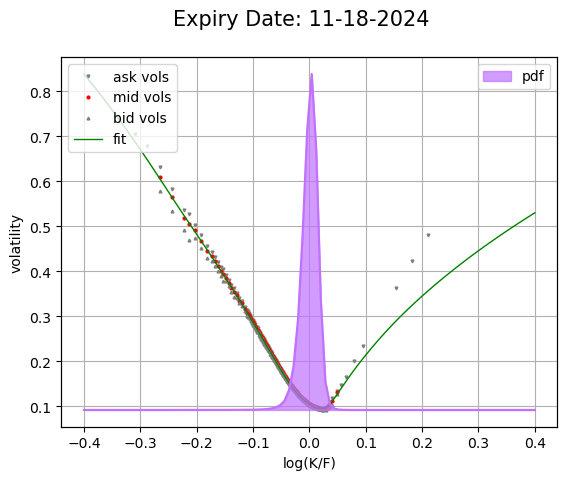

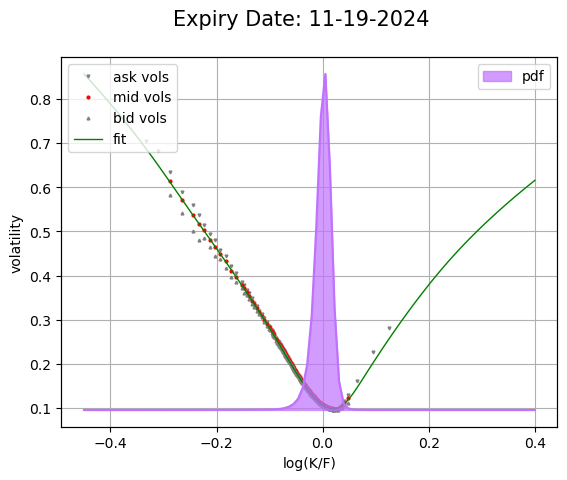

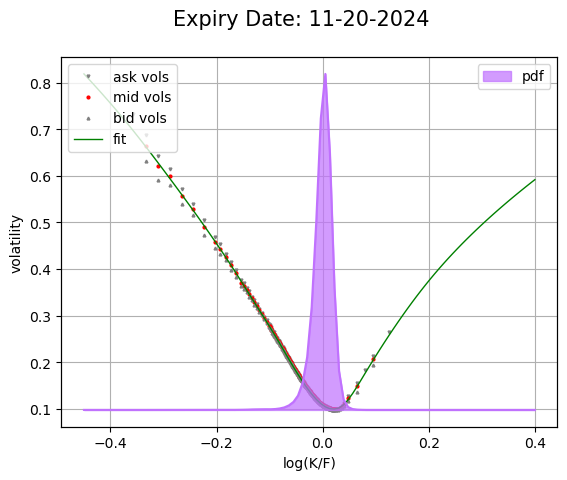

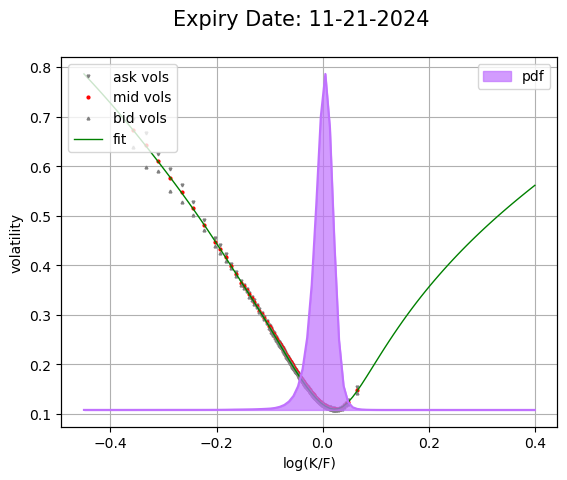

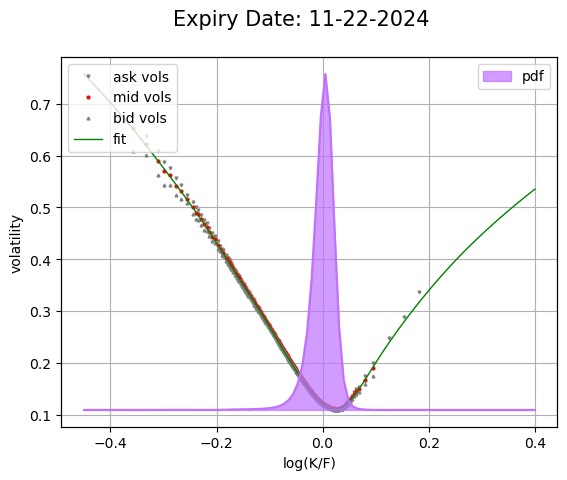

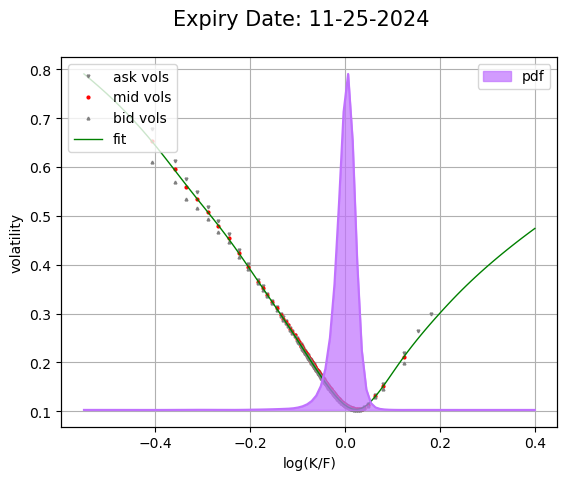

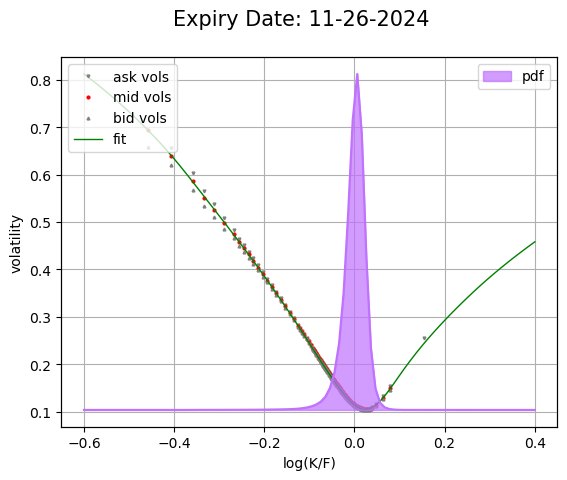

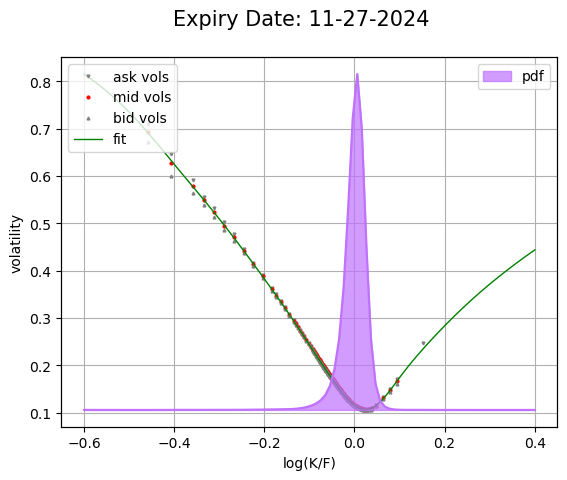

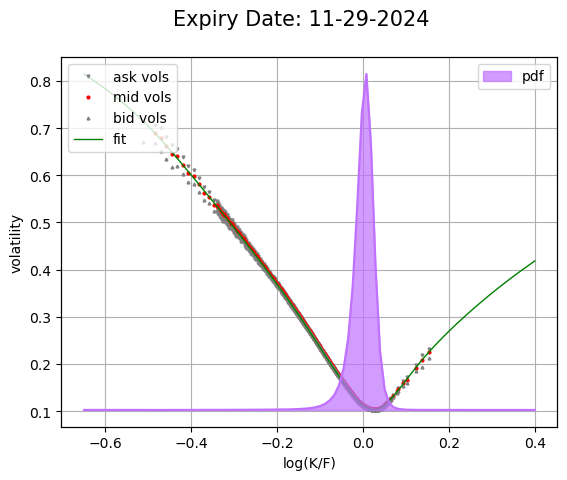

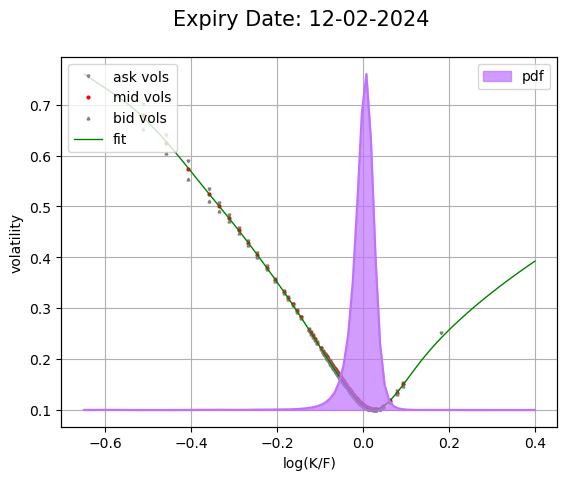

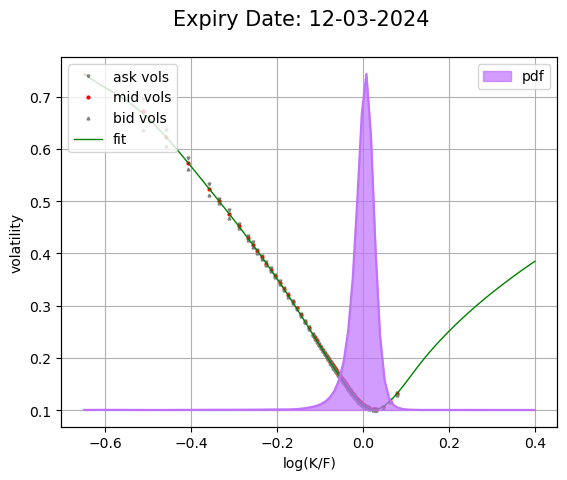

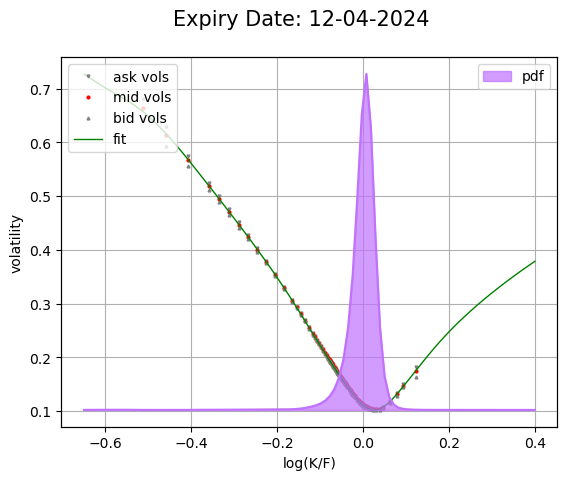

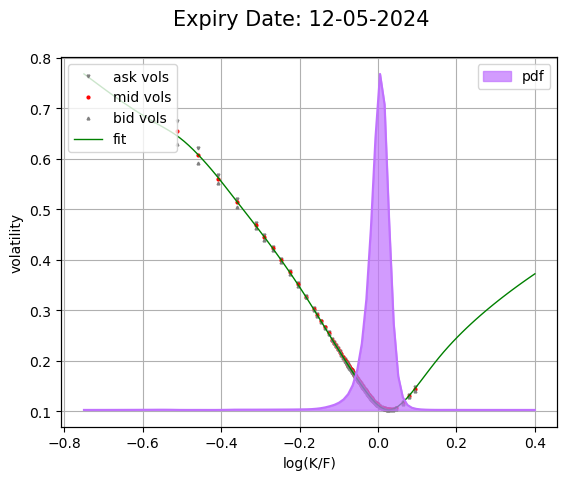

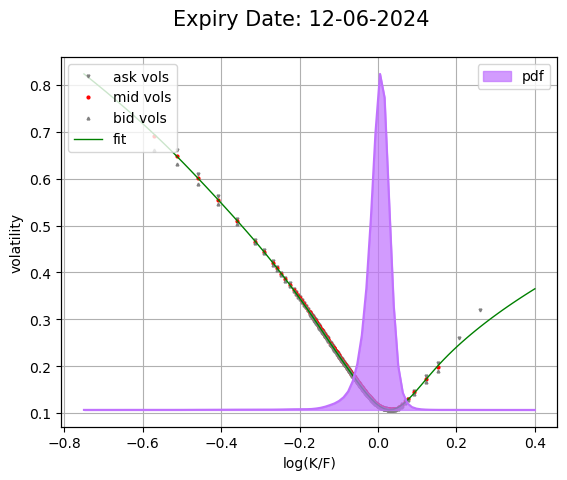

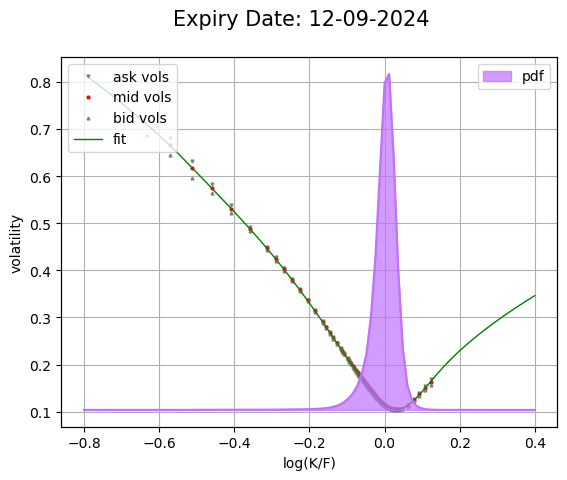

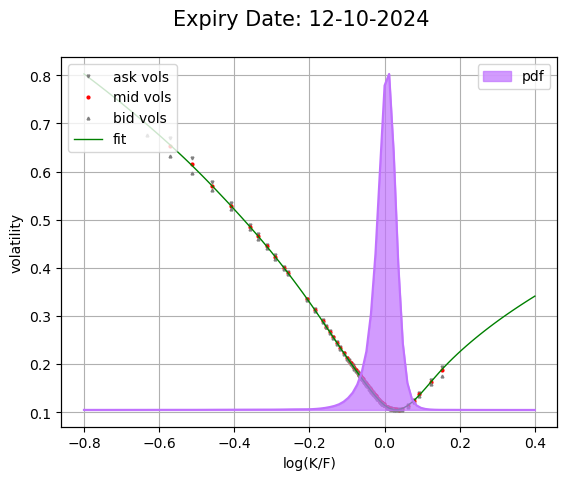

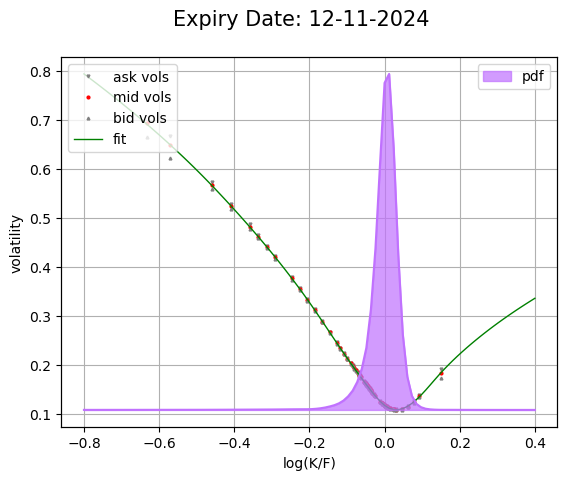

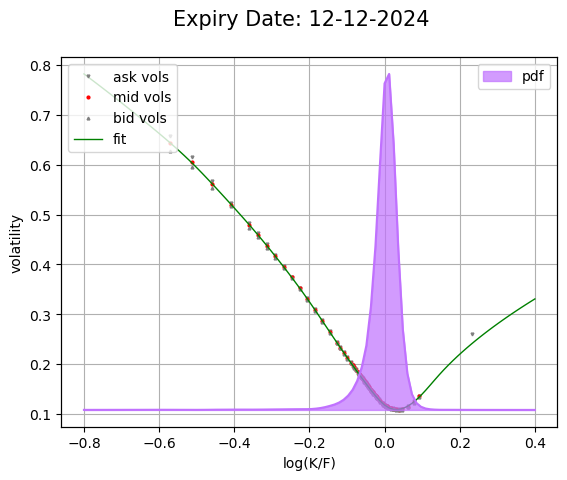

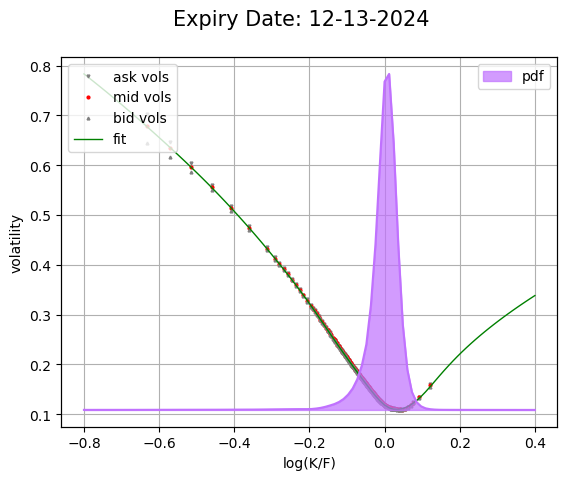

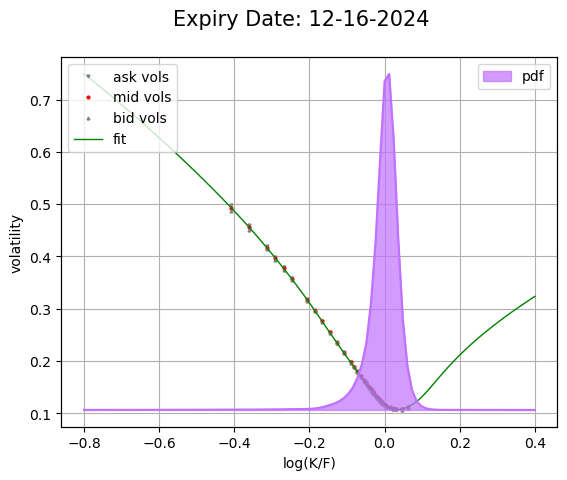

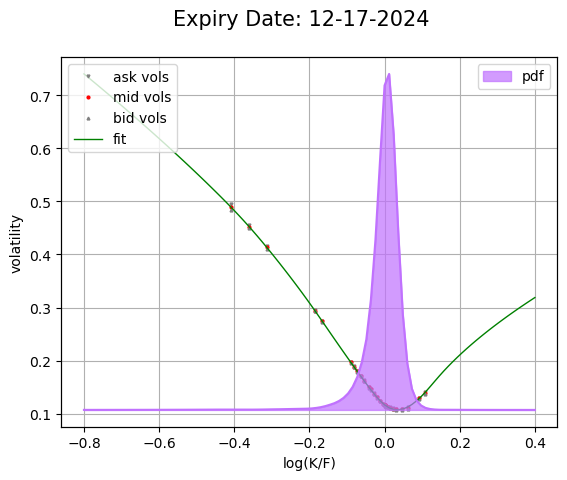

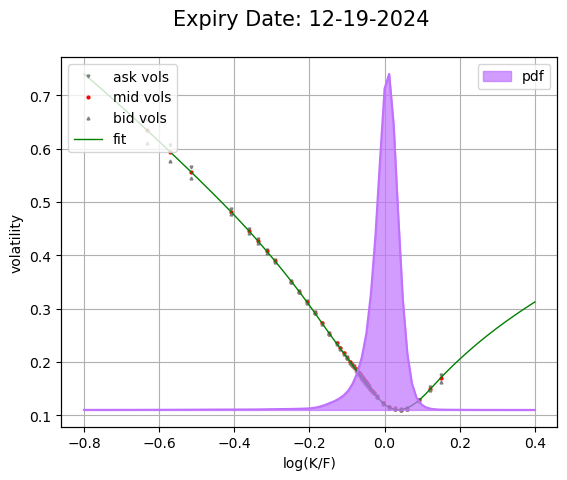

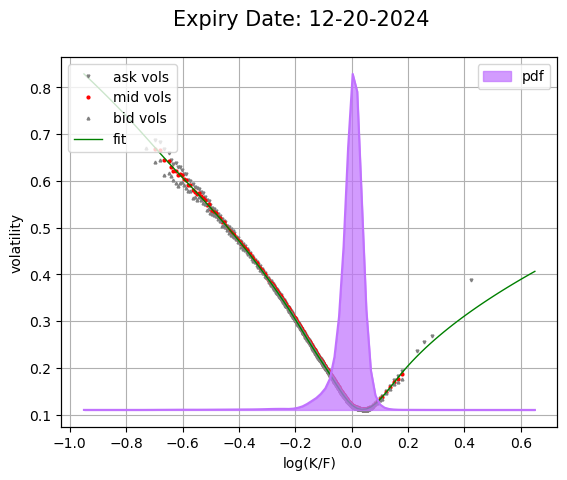

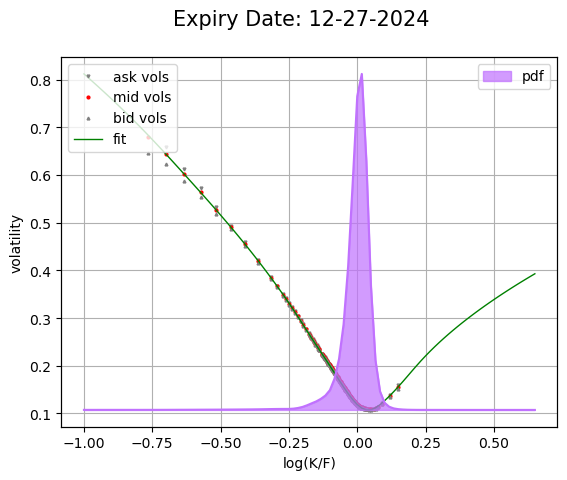

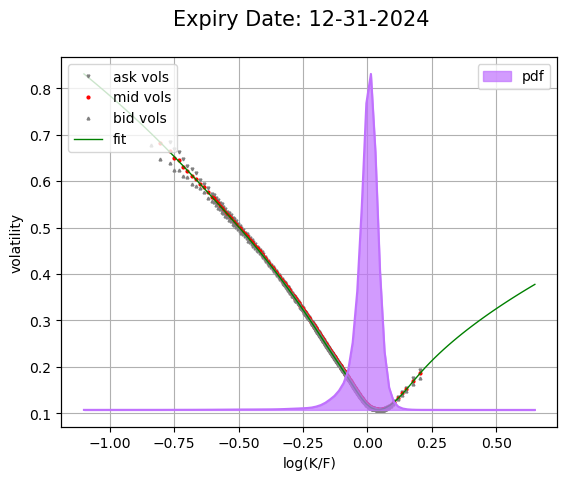

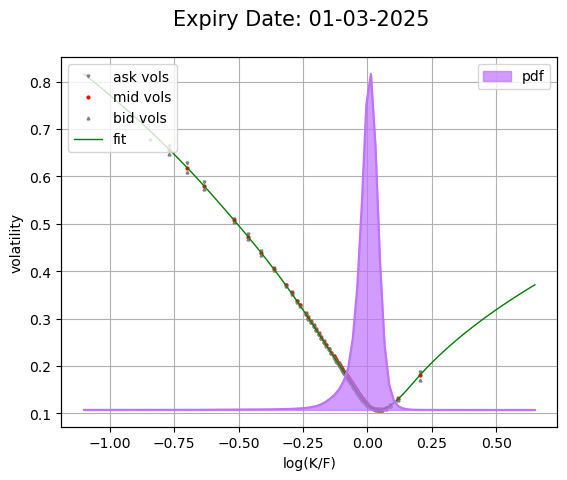

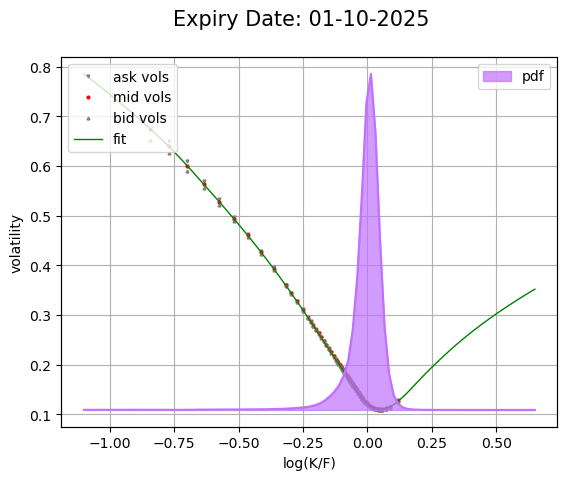

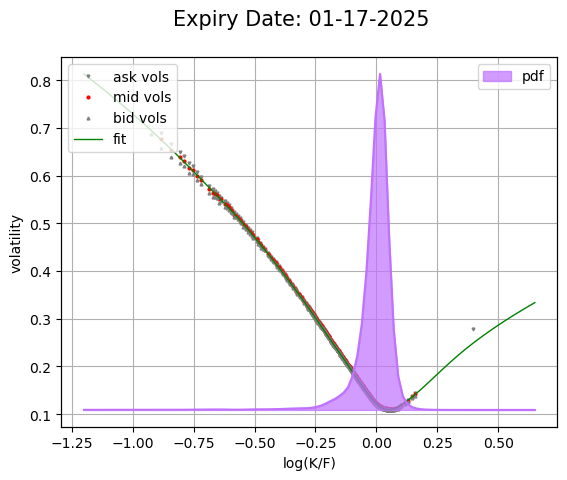

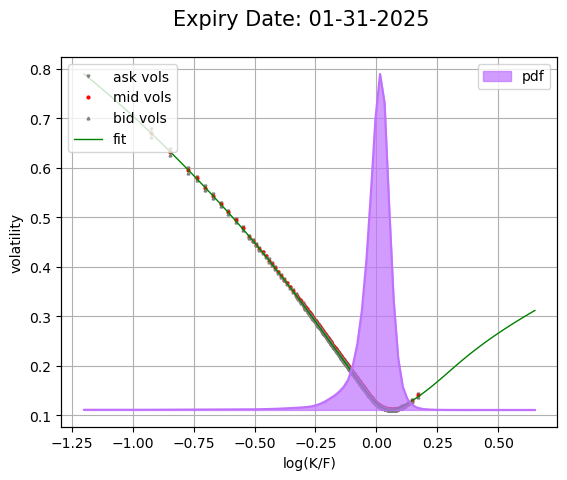

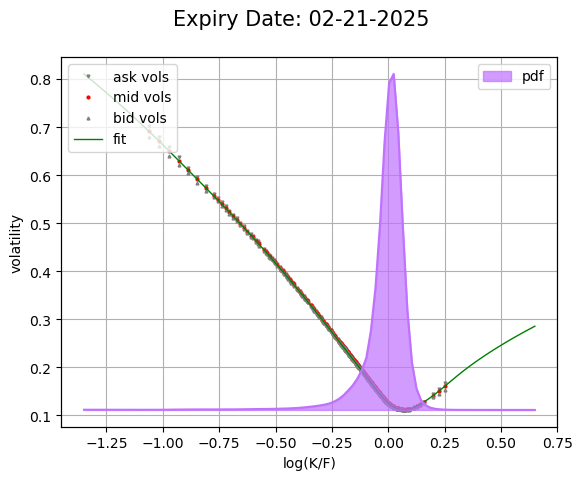

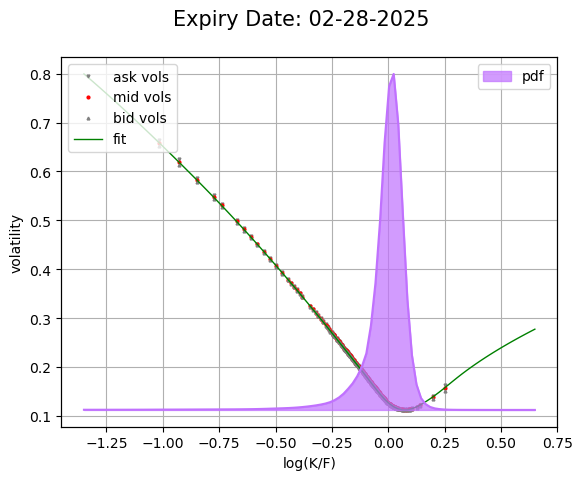

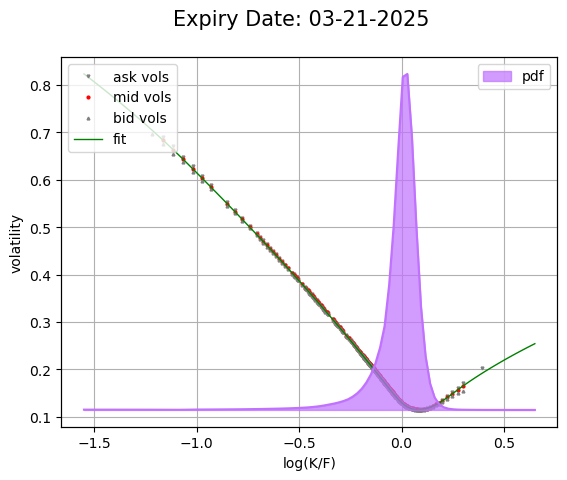

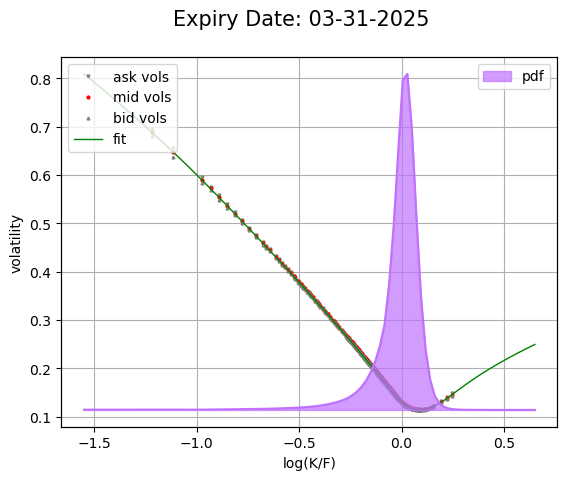

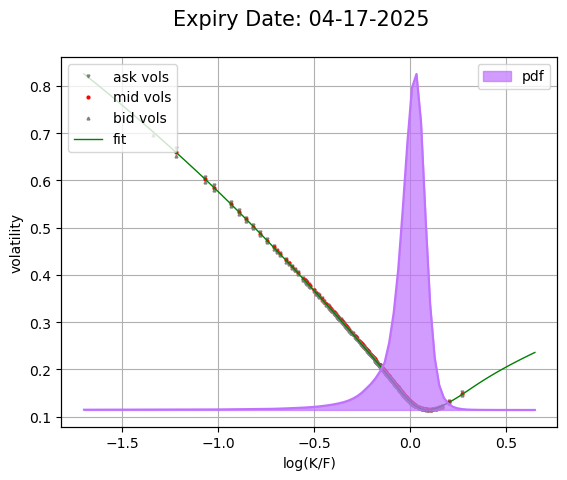

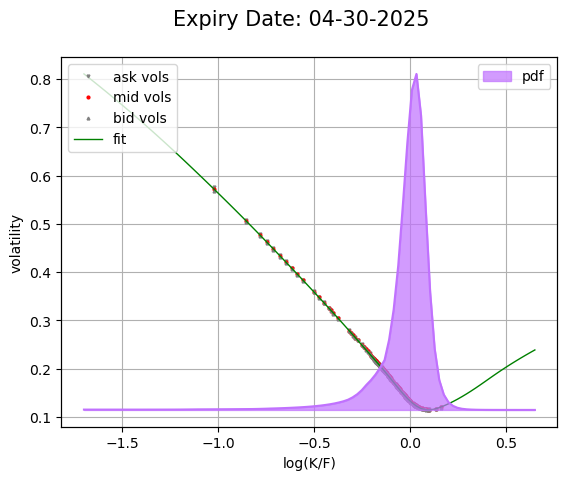

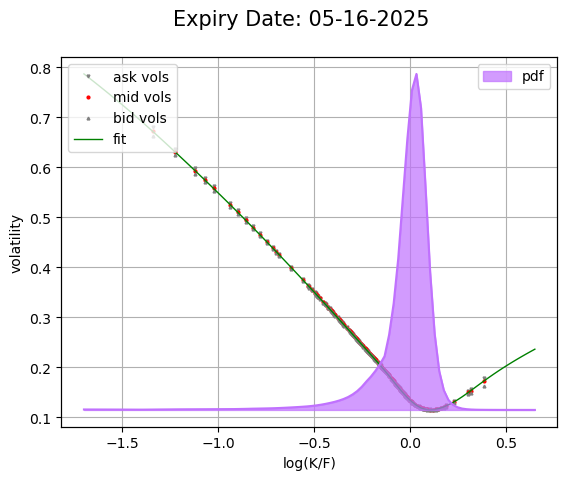

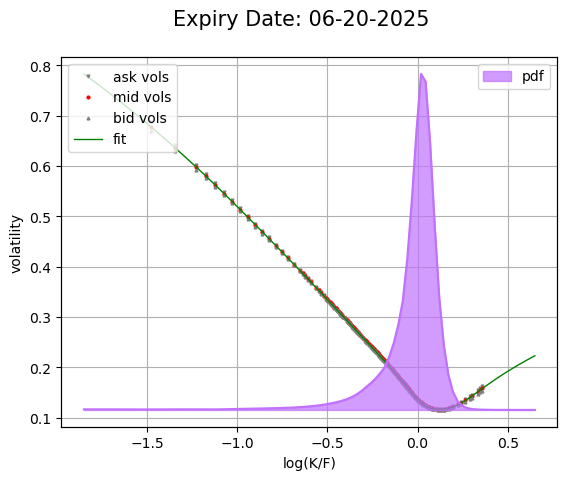

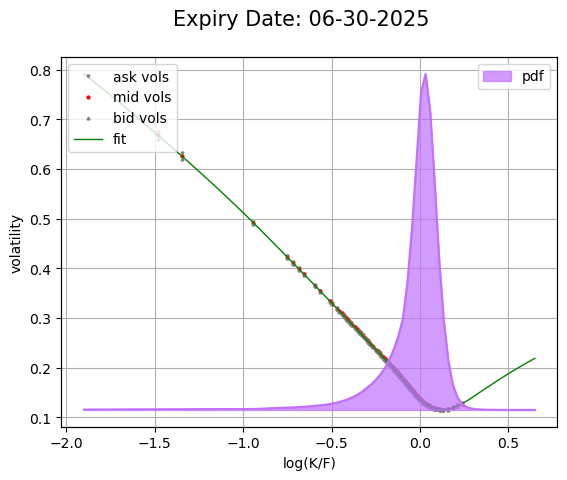

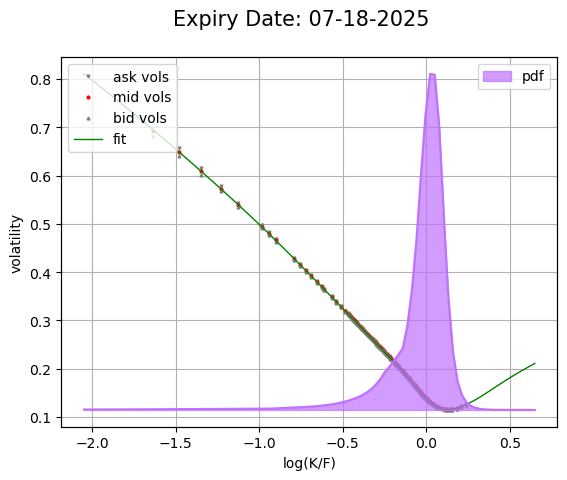

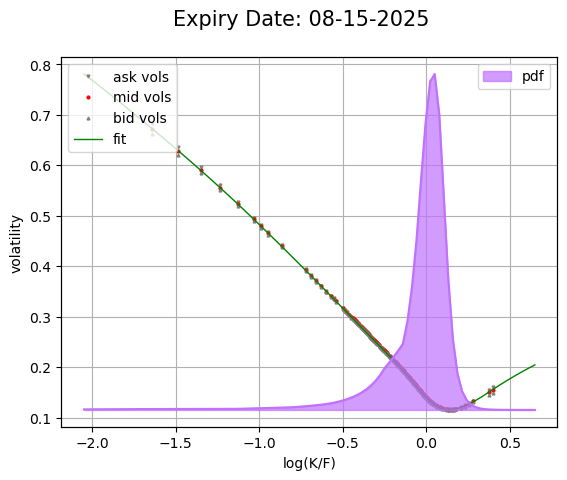

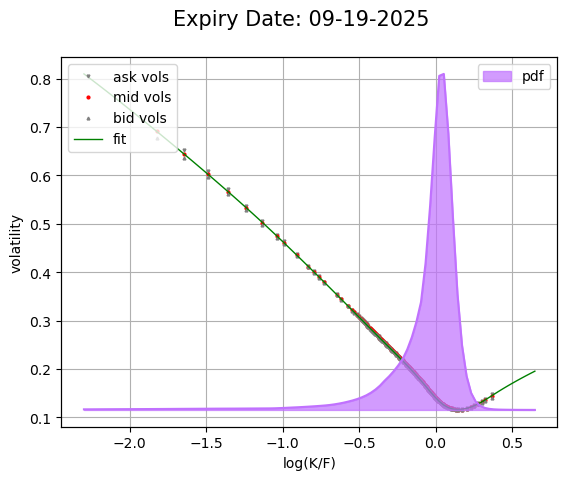

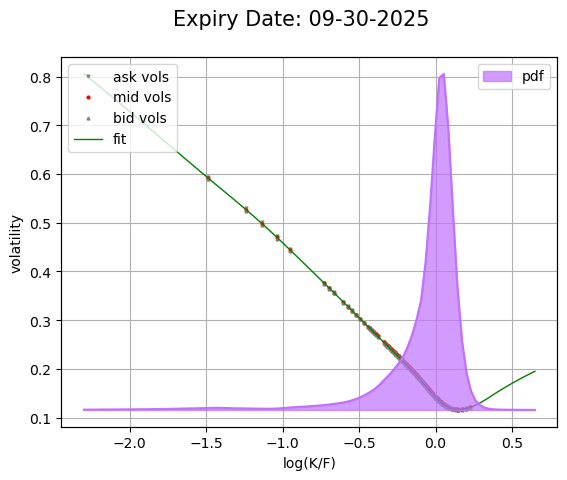

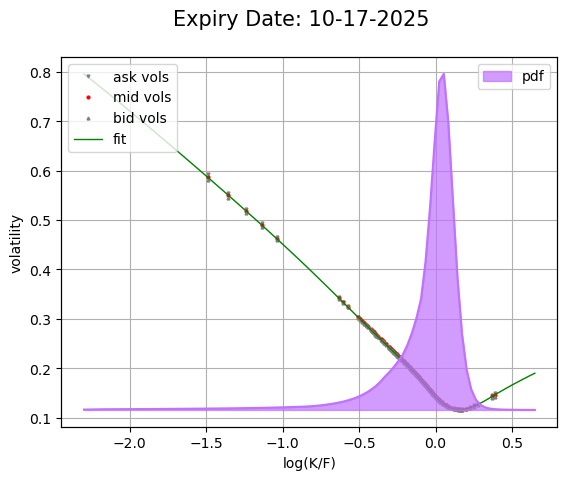

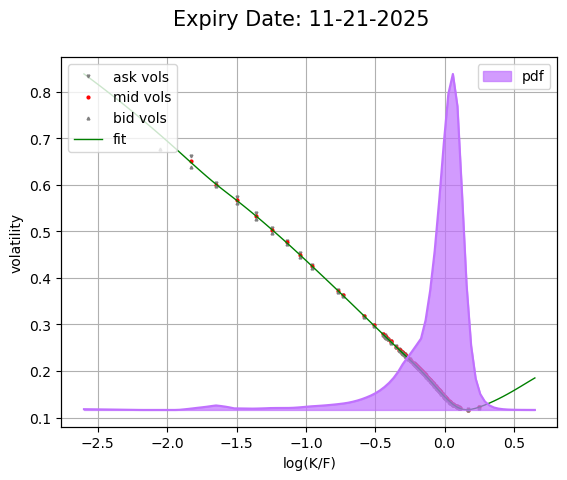

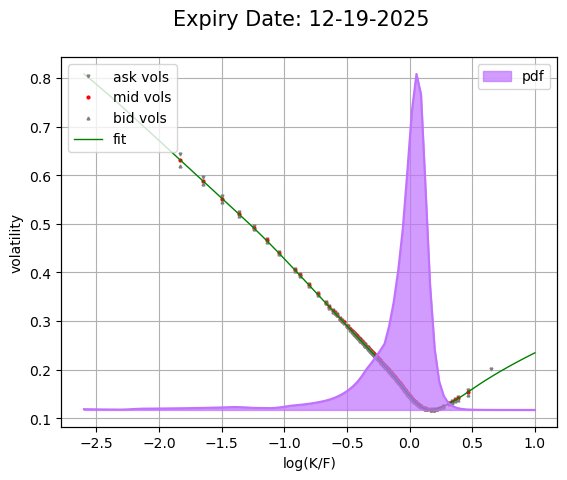

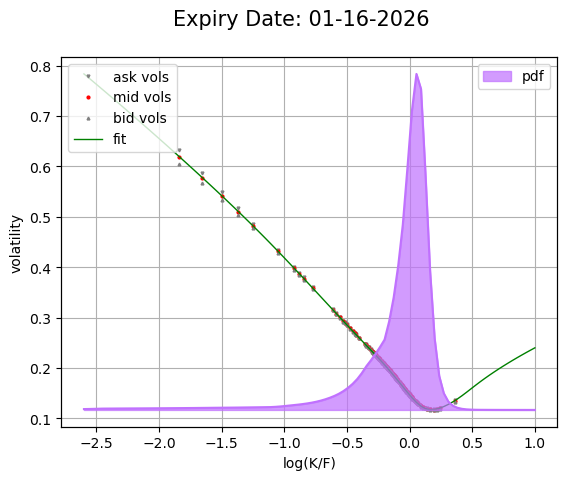

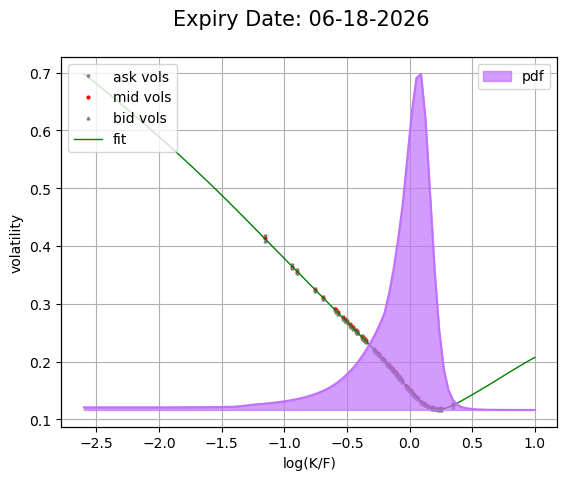

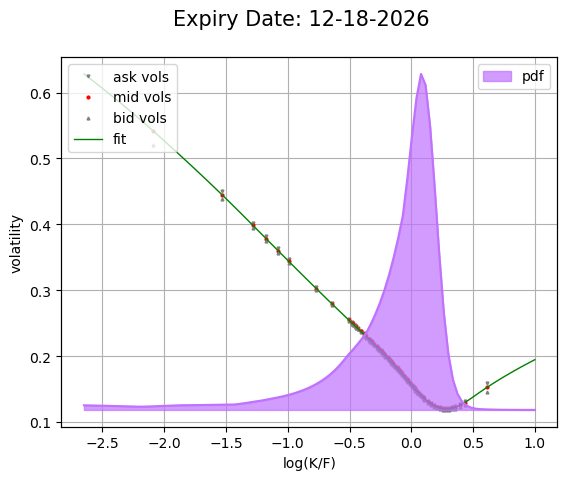

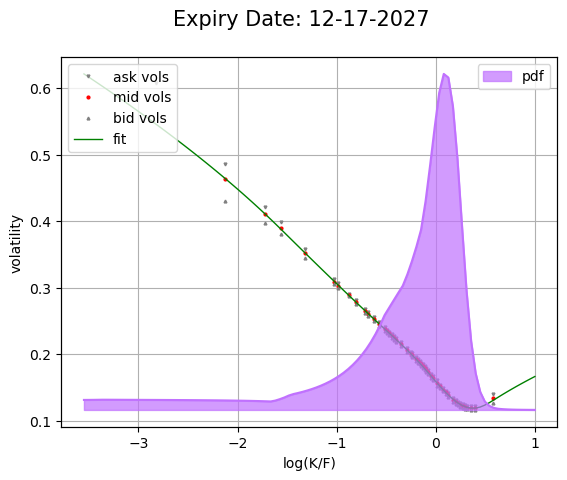

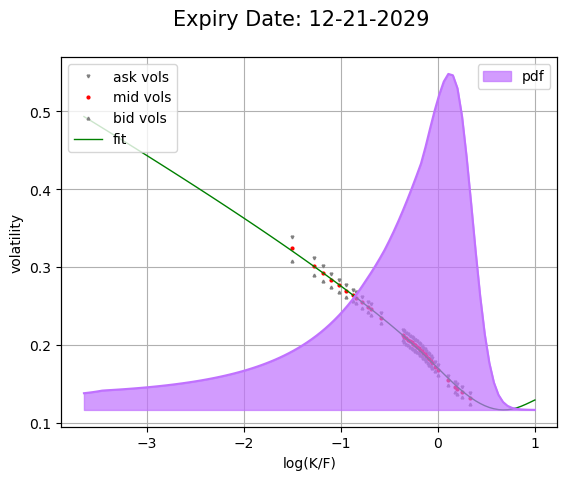

In [97]:
for i in range(len(tenors)):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    t_data = df[df['Tenor']==tenors[i]].loc[:].reset_index(drop=True)
    expiry = t_data.loc[0, 'Expiry Date'].strftime(format='%m-%d-%Y')
    spline_vols = np.sqrt(v_refs[i])
    ax1.plot(t_data['k'], t_data['AskVol'], 'v', ms=2, color='grey', label='ask vols')
    ax1.plot(t_data['k'], t_data['MidVol'], 'o', ms=2, color='red', label='mid vols')
    ax1.plot(t_data['k'], t_data['BidVol'], '^', ms=2, color='grey', label='bid vols')
    ks = z_grid[i] * (atmf_vols_est[i] * tenors[i]**0.5)
    ax1.plot(ks, spline_vols, '-', label='fit', color='green', lw=1)
    ax2.plot(k_grid[i], pdfs[i], color='#c071fe')
    ax2.fill_between(x= k_grid[i], y1= pdfs[i], color= '#c071fe', alpha= 0.7, label='pdf')
    ax1.set_xlabel('log(K/F)')
    ax1.set_ylabel('volatility')
    ax2.set_yticks([])
    fig.suptitle('Expiry Date: ' + expiry, fontsize=15)
    plt.sca(ax1)
    plt.gca().xaxis.grid(True)
    plt.gca().yaxis.grid(True)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

## __References__

1. Deschâtres, Fabrice, Convex Volatility Interpolation (May 26, 2024). Available at SSRN: https://ssrn.com/abstract=4831218 or http://dx.doi.org/10.2139/ssrn.4831218
2. Guo, Huayuan and Liu, Minchao and Qin, Guiming and Qin, Kaihuai and He, Kunlun, General Matrix Representation for Generalized B-Splines and Its Application. Available at SSRN: https://ssrn.com/abstract=4563829 or http://dx.doi.org/10.2139/ssrn.4563829